## Bechdel Data Analysis

The Bechdel Test, or Bechdel-Wallace Test, sometimes called the Mo Movie Measure or Bechdel Rule is a simple test 
 which names the following three criteria: \
 1. it has to have at least two women in it, who \
 2. who talk to each other, about \
 3. something besides a man.

The test serves as a lens to evaluate whether a film provides meaningful interaction between female characters, reflecting broader trends in the portrayal of women in the film industry.

In this analysis, we will explore how Bechdel Test results have evolved over the years and across different regions of the world. We will also investigate how these scores relate to other aspects of films, such as revenue, ratings, and the presence of female lead actors.

By examining these relationships, our goal is to understand whether the representation of women in cinema has improved over time and whether films that perform well on the Bechdel Test are correlated with greater success. We aim to validate the theory that female representation is becoming more significant in the industry, potentially influencing a film's reception and success.

In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
import json
import math
from statsmodels.stats import diagnostic
from scipy import stats
from numpy.polynomial.polynomial import Polynomial

### Getting the Bechdel test database and the Movie database

The code below is used to get the Bechdel test results from the API and store them in a DataFrame

In [3]:

url = 'http://bechdeltest.com/api/v1/getAllMovies'

response = requests.get(url)

if response.status_code == 200:
    print('Request was succesful')
    movie_data = response.json()
    df_bechdel = pd.DataFrame(movie_data)
    print(df_bechdel.sample())

else:
    print('Request failed')

Request was succesful
      year          title    id   imdbid  rating
9195  2018  Hold the Dark  8495  5057140       1


In [4]:
#We now want to get a quick glimpse of the dataset

print(f'The Bechdel database has {df_bechdel.shape[0]} films')
df_bechdel.sample(10)

The Bechdel database has 10408 films


,year,title,id,imdbid,rating
7909,2014,Penguins of Madagascar,5950,1911658,0
5145,2006,Hogfather,3785,0765458,3
1915,1979,Being There,1699,0078841,2
5406,2007,My Blueberry Nights,2655,0765120,3
1038,1960,"Story of Ruth, The",5123,0054343,3
8818,2017,John Wick: Chapter 2,7446,4425200,1
7122,2012,Contraband,3979,1524137,3
2294,1985,Phenomena,4893,0087909,3
3532,1997,An American Werewolf in Paris,7675,0118604,1
13,1888,Roundhay Garden Scene,8040,0392728,0


We are now going to extract the CMU Movie Database, to get additional information from those films 

In [5]:
data_folder = './MovieSummaries/'

column_names= ['wikipedia_movie_id', 'freebase_id','title','release_date','revenue','runtime','language','countries','genre']

df_movies=pd.read_csv(data_folder + 'movie.metadata.tsv', sep = '\t', names=column_names)

print(f'The CMU Movies database has {df_movies.shape[0]} films')
df_movies.sample(5)


The CMU Movies database has 81741 films


,wikipedia_movie_id,freebase_id,title,release_date,revenue,runtime,language,countries,genre
13281,6525562,/m/0g8xvj,Dense,2004-04-21,NaN,35.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/07s9rl0"": ""Dra..."
75395,4046605,/m/0bf8y7,No Exit,1995,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/02kdv5l"": ""Actio..."
24816,10056433,/m/076ydfg,Los Miedos,1980,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/03npn"": ""Horror"", ""/m/07s9rl0"": ""Drama""}"
59571,5444176,/m/0dm4v9,Love's Berries,1926,NaN,30.0,"{""/m/06ppq"": ""Silent film""}","{""/m/05vz3zq"": ""Soviet Union""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
31736,32066977,/m/0gx0nqq,Somebody's Darling,1925-12-10,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/05p553"": ""Comedy film""}"


#### Code taken from Elsa's branch

This can be deleted if already working with the cleaned dataset

In [6]:
wrong_values = df_movies[
    (df_movies['runtime'] <= 0) |
    (df_movies['runtime'] > 14400)
]

df_movies.loc[wrong_values.index, 'runtime'] = pd.NA

print(f"There are {wrong_values.shape[0]} movies with invalid runtimes. These have been replaced with NaNs.")

There are 2 movies with invalid runtimes. These have been replaced with NaNs.


#### Again my code

In [7]:
#We are going to create a database where we merge the bechdel and the movie database, so that we can have all of the information of those films 
# in one single dataframe. We will merge it on year and title, to avoid having one title of he Bechdel database to many movies in the movie database.

# Convert release_date to datetime format (if it's not already in datetime)
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], errors='coerce')

# Extract the year from the release_date column
df_movies['year'] = df_movies['release_date'].dt.year

# Merge the datasets by 'title' and 'year'
df_movies_bechdel = pd.merge(df_movies, df_bechdel, how='inner', on=['title', 'year'])


df_movies_bechdel = df_movies_bechdel.rename(columns={'rating':'bechdel_score'})
df_movies_bechdel = df_movies_bechdel.drop(columns=['id']) 
df_movies_bechdel = df_movies_bechdel.drop_duplicates(['title','wikipedia_movie_id'])


print(f'The combined Bechdel and CMU Movies database has {df_movies_bechdel.shape[0]} films')

df_movies_bechdel.head()

The combined Bechdel and CMU Movies database has 3121 films


,wikipedia_movie_id,freebase_id,title,release_date,revenue,runtime,language,countries,genre,year,imdbid,bechdel_score
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,0228333,3
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989.0,0097499,3
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964.0,0058331,3
3,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",1989.0,0097790,3
4,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/04t36"": ""Musical...",1968.0,0063642,3


### Bechdel test results along the years

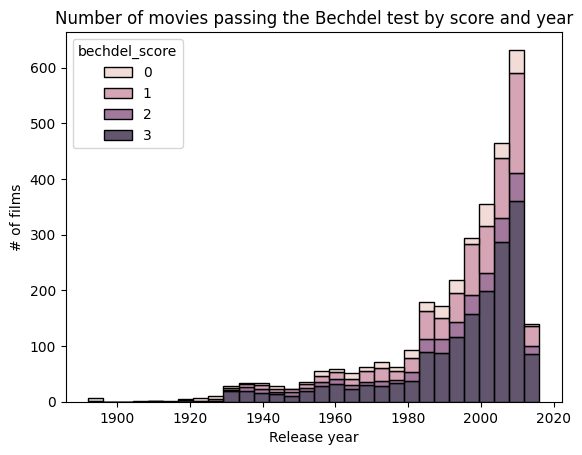

In [8]:
#we here want to plot the number of movies passing the Bechdel test by year and by score

sns.histplot(data=df_movies_bechdel, x='year', hue='bechdel_score',multiple='stack',bins=30)

plt.title('Number of movies passing the Bechdel test by score and year')
plt.xlabel('Release year')
plt.ylabel('# of films');




We observe a clear increase in the number of films passing the Bechdel Test over the years. 

Let's now plot the evolution of the number of films for different scores plotted separately

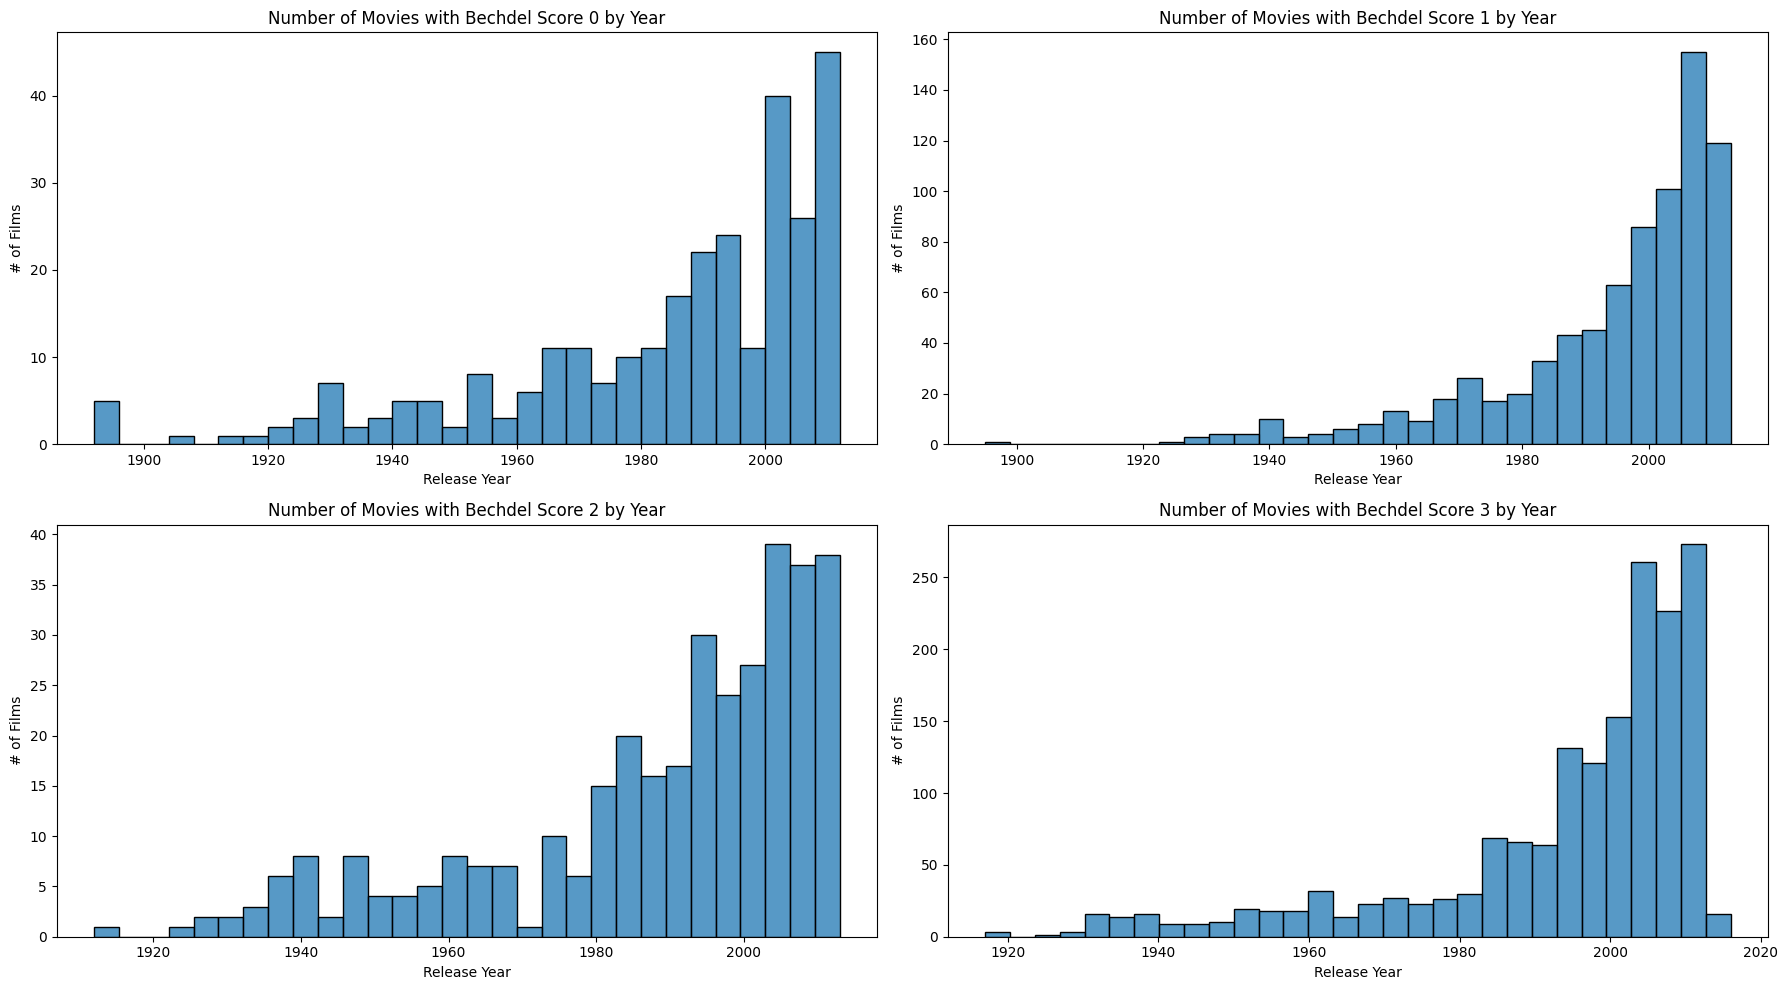

In [9]:
# Set up the figure with 4 subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Define the scores and axes
scores = [0, 1, 2, 3]
titles = [
    "Number of Movies with Bechdel Score 0 by Year",
    "Number of Movies with Bechdel Score 1 by Year",
    "Number of Movies with Bechdel Score 2 by Year",
    "Number of Movies with Bechdel Score 3 by Year"
]

# Loop through each score and corresponding axis
for i, (score, ax) in enumerate(zip(scores, axes.flatten())):
    sns.histplot(
        data=df_movies_bechdel.query(f'bechdel_score == {score}'), 
        x='year', 
        bins=30, 
        ax=ax
    )
    ax.set_title(titles[i])
    ax.set_xlabel('Release Year')
    ax.set_ylabel('# of Films')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


#Here, we will color each score with the ones attributed above

By looking at the scale of the graphs, we can suppose that indeed we now have many more films passing the Bechdel test than failing it.

However, it's still uncertain whether the proportion of films meeting these criteria has genuinely improved over time. To investigate this further, we will analyze the correlation between release years and the average Bechdel Test scores. Additionally, we will visualize the trend by plotting the average scores by year, supplemented with a linear regression line to highlight any patterns.

Pearson Correlation Coefficient: 0.4883, p-value: 1.92402706028908e-07, intercept=-17.97


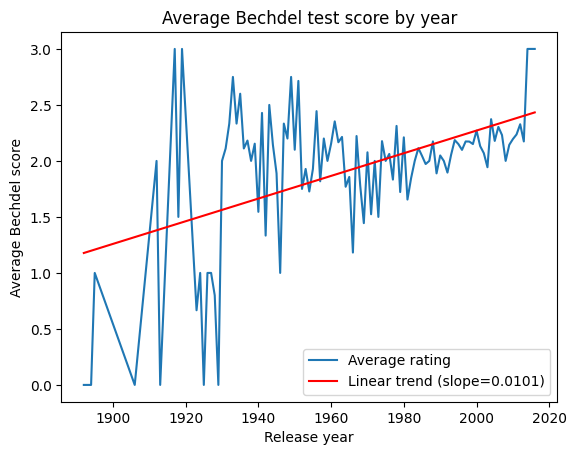

In [10]:
df_year_mbechdel = df_movies_bechdel.groupby('year')['bechdel_score'].agg('mean').reset_index() # Here, we reset index to get the year as a column
df_year_mbechdel = df_year_mbechdel.rename(columns={'bechdel_score':'avg_bechdel_score'})

slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_mbechdel['year'],df_year_mbechdel['avg_bechdel_score'])

sns.lineplot(data=df_year_mbechdel, x='year', y='avg_bechdel_score', label='Average rating')
plt.plot(df_year_mbechdel['year'], slope*df_year_mbechdel['year']+intercept, color='red',label=f'Linear trend (slope={slope:.4f})')

plt.legend()

plt.title('Average Bechdel test score by year')
plt.xlabel('Release year')
plt.ylabel('Average Bechdel score');

print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")


By these results, we can observe that the Bechdel test results definitely go up as the years go by. This can be interpreted from our positive slope and our negative intercept in the linear regression. Nevertheless our rvalue (or Pearson Correlation Coefficent) tells us that less than half of this increment is due to time passing by. With the other 50% being due to other factors, like gere, budget or country of creation.

Lastly, we can affirm that this relationship is most probably not due to randomness, since our p-value is remarkably small.

#### However

We discovered that doing this with the original Bechdel database yielded a quite different result for the pearson correlation coefficient:

Pearson Correlation Coefficient: 0.8064, p-value: 5.662079183511133e-34, intercept=-30.05


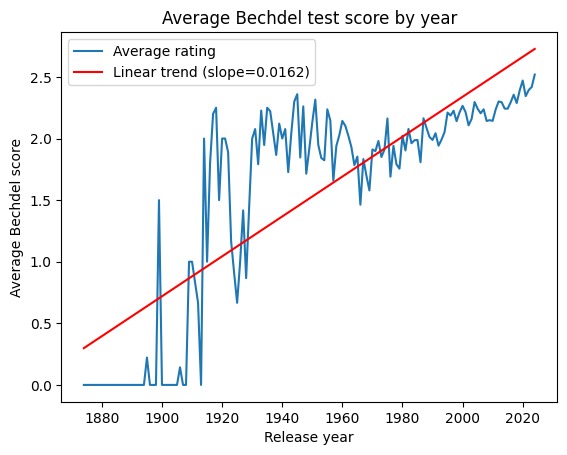

In [11]:
df_year_bechdel = df_bechdel.groupby('year')['rating'].agg('mean').reset_index() # Here, we reset index to get the year as a column
df_year_bechdel = df_year_bechdel.rename(columns={'rating':'avg_bechdel_score'})

slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel['year'],df_year_bechdel['avg_bechdel_score'])

sns.lineplot(data=df_year_bechdel, x='year', y='avg_bechdel_score', label='Average rating')
plt.plot(df_year_bechdel['year'], slope*df_year_bechdel['year']+intercept, color='red',label=f'Linear trend (slope={slope:.4f})')

plt.legend()

plt.title('Average Bechdel test score by year')
plt.xlabel('Release year')
plt.ylabel('Average Bechdel score');

print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")


For the original Bechdel Test database, we observe a slope that is 60% steeper, with an even lower intercept and an r-value of around 0.8. This indicates that the Bechdel Test results have a stronger correlation with the release year than previously determined. It is surprising that reducing the dataset to only films present in both databases results in such a different correlation.

By comparing both graphs, it appears that the merged database has fewer films from the late 1800s and early 1900s. However, this observation can be easily confirmed:

All unselected films: Pearson Correlation Coefficient: 0.8019, p-value: 2.3815640449128354e-33, intercept=-31.17
Unselected films after 1920: Pearson Correlation Coefficient: 0.5738, p-value: 1.9231823716772625e-10, intercept=-10.78
Unselected films before 2020: Pearson Correlation Coefficient: 0.7962, p-value: 1.7974102832853303e-31, intercept=-32.04


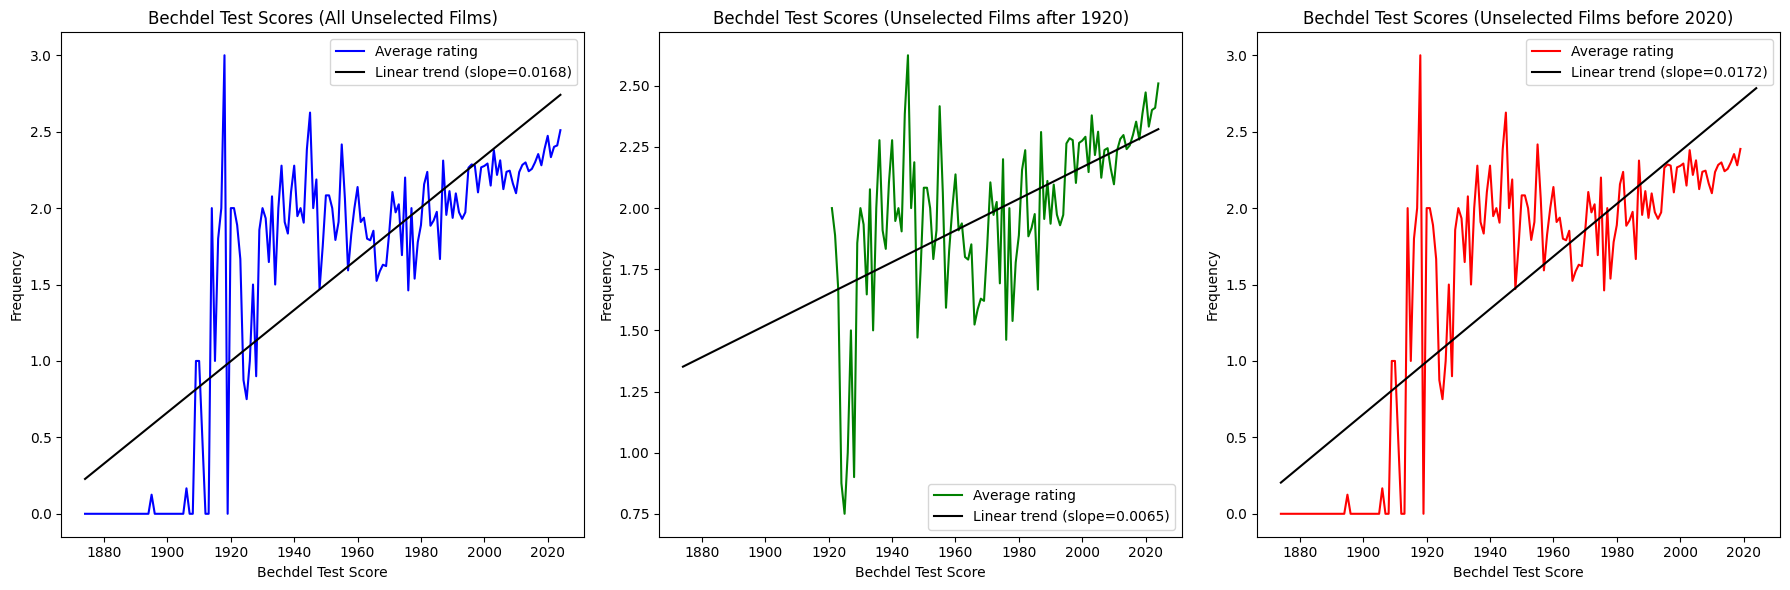

In [12]:
df_bechdel_notmerged=df_bechdel[~df_bechdel['title'].isin(df_movies_bechdel['title'])]

df_year_bechdel_n = df_bechdel_notmerged.groupby('year')['rating'].agg('mean').reset_index() # Here, we reset index to get the year as a column
df_year_bechdel_n = df_year_bechdel_n.rename(columns={'rating':'avg_bechdel_score'})

# Set up the figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: All unselected films (Bechdel scores)
slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel_n['year'],df_year_bechdel_n['avg_bechdel_score'])

sns.lineplot(data=df_year_bechdel_n, x='year', y='avg_bechdel_score', label='Average rating', ax=axes[0], color='blue')
axes[0].plot(df_year_bechdel['year'],slope * df_year_bechdel['year'] + intercept,color='black',label=f'Linear trend (slope={slope:.4f})')

axes[0].set_title('Bechdel Test Scores (All Unselected Films)')
axes[0].set_xlabel('Bechdel Test Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

print(f"All unselected films: Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")

# Plot 2: Unselected films excluding those before 1920
slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel_n.query('1920<year')['year'],df_year_bechdel_n.query('1920<year')['avg_bechdel_score'])

sns.lineplot(data=df_year_bechdel_n.query('1920<year'), x='year', y='avg_bechdel_score', label='Average rating', ax=axes[1], color='green')
axes[1].plot(df_year_bechdel['year'],slope * df_year_bechdel['year'] + intercept,color='black',label=f'Linear trend (slope={slope:.4f})')

axes[1].set_title('Bechdel Test Scores (Unselected Films after 1920)')
axes[1].set_xlabel('Bechdel Test Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()

print(f"Unselected films after 1920: Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")

# Plot 3: Unselected films excluding those after 2020
slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel_n.query('2020>year')['year'],df_year_bechdel_n.query('2020>year')['avg_bechdel_score'])

sns.lineplot(data=df_year_bechdel_n.query('2020>year'), x='year', y='avg_bechdel_score', label='Average rating', ax=axes[2], color='red')
axes[2].plot(df_year_bechdel['year'],slope * df_year_bechdel['year'] + intercept,color='black',label=f'Linear trend (slope={slope:.4f})')

axes[2].set_title('Bechdel Test Scores (Unselected Films before 2020)')
axes[2].set_xlabel('Bechdel Test Score')
axes[2].set_ylabel('Frequency')
axes[2].legend()

print(f"Unselected films before 2020: Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


We observe that films released before 1920 have a lower average Bechdel test score and significantly influence the correlation between the year of release and the average Bechdel test score.

This is particularly interesting because it suggests that when compiling the Bechdel test database, considerable attention was paid to early cinema, including films from the industry's origins. This focus on early films could explain the stronger correlation observed in the earlier years. Which is not observable in our merged dataset

Based on this analysis, we can draft these two theories:

1. The Bechdel test results have improved over time, indicating a gradual shift towards more meaningful female representation in films.\
        Women were largely absent from lead roles in the early years of cinema, as reflected by the lower Bechdel test scores for films released before 1920.\
2. These conclusions highlight both the historical progression of women's roles in film and the evolving impact of the Bechdel test as a measure\
    of female representation in cinema.

### Bechdel Test Results in Different World Regions

To analyze how the Bechdel test results have evolved across various world regions, we opted to categorize the films by continent. This approach was chosen to avoid the complexities of geopolitical definitions. By utilizing the pycountry_convert library, we can efficiently convert countries into their respective continents.

For simplicity and based on the assumption that the first country listed in the data is the primary producer or responsible entity for the film, we decided to use only the first country in the list to determine the continent.

In [13]:
df_movies_bechdel['countries'].value_counts()

def get_continent(country_list):
    try:
        country_dict=json.loads(country_list)

        if not country_dict:
            return None

        country_name = list(country_dict.values())[0] #I might need to have different continents! Here I only have the first one!
        country_alpha2=pc.country_name_to_country_alpha2(country_name)
        return pc.country_alpha2_to_continent_code(country_alpha2)
    except KeyError or IndexError:
        return None

df_movies_bechdel['continent']=df_movies_bechdel['countries'].apply(get_continent)

df_movies_bechdel['continent'].value_counts()

continent
NA    2521
EU     403
AS     124
OC      21
SA       4
Name: count, dtype: int64

There is a noticeable underrepresentation of non-North American and non-European films in the Bechdel test database. This disparity can be attributed to the test's popularity being primarily concentrated in North America, with limited focus on international films in the analysis.

For clarity and a more focused visualization, we will restrict the plots to films from North America, Europe, and Asia.

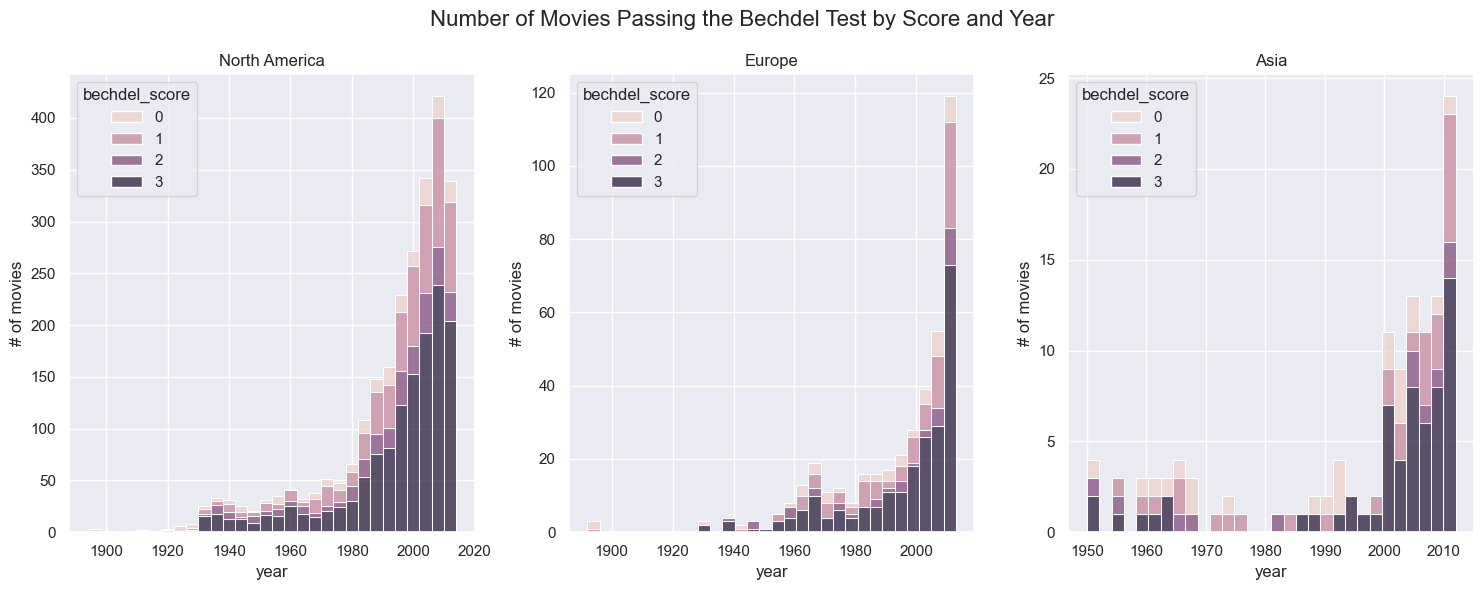

In [14]:
#by region now

sns.set()

fig, axes = plt.subplots(1,3, figsize = (15,6))

fig.suptitle('Number of Movies Passing the Bechdel Test by Score and Year', fontsize=16)

sns.histplot(data=df_movies_bechdel[df_movies_bechdel['continent'] == 'NA'], x='year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[0]).set(title='North America', 
                                                                                                                          ylabel = '# of movies')
sns.histplot(data=df_movies_bechdel[df_movies_bechdel['continent'] == 'EU'], x='year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[1]).set(title='Europe', 
                                                                                                                          ylabel = '# of movies')
sns.histplot(data=df_movies_bechdel[df_movies_bechdel['continent'] == 'AS'], x='year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[2]).set(title='Asia', 
                                                                                                                          ylabel = '# of movies')

plt.tight_layout();




As observed previously, the number of films passing the Bechdel test has increased, but we cannot draw definitive conclusions about the proportion of films passing or failing the test.

Similar to our earlier analysis, we will now calculate the averages by continent. Our first step will be to identify the continents for which we have a significant correlation between the year of release and the average Bechdel test score. This will be assessed using Pearson regression.

In [15]:
df_avg_continent = df_movies_bechdel.pivot_table(
    index='year', 
    columns='continent', 
    values='bechdel_score', 
    aggfunc='mean'
).reset_index()

df_avg_continent.columns = ['year'] + [f'avg_bechdel_score_{col}' for col in df_avg_continent.columns[1:]]


r_score_NA,p_score_NA=stats.pearsonr(df_avg_continent.loc[df_avg_continent['avg_bechdel_score_NA'].notna(),'year'], 
                                    df_avg_continent.loc[df_avg_continent['avg_bechdel_score_NA'].notna(), 'avg_bechdel_score_NA'])
print(f'Pearson regression NA r-score: {r_score_NA:.4f}, p-score:{p_score_NA}')

r_score_EU,p_score_EU=stats.pearsonr(df_avg_continent.loc[df_avg_continent['avg_bechdel_score_EU'].notna(),'year'], 
                                    df_avg_continent.loc[df_avg_continent['avg_bechdel_score_EU'].notna(), 'avg_bechdel_score_EU'])
print(f'Pearson regression EU r-score: {r_score_EU:.4f}, p-score:{p_score_EU}')

r_score_AS,p_score_AS=stats.pearsonr(df_avg_continent.loc[df_avg_continent['avg_bechdel_score_AS'].notna(),'year'], 
                                    df_avg_continent.loc[df_avg_continent['avg_bechdel_score_AS'].notna(), 'avg_bechdel_score_AS'])
print(f'Pearson regression AS r-score: {r_score_AS:.4f}, p-score:{p_score_AS}')

Pearson regression NA r-score: 0.4273, p-score:1.0314173768176473e-05
Pearson regression EU r-score: 0.1829, p-score:0.12683329392506348
Pearson regression AS r-score: 0.2050, p-score:0.18723658561998563


We are unable to perform a linear regression for Europe nor Asia due to very high p-values. This is likely a result of the small number of films from these regions in the Bechdel test database, which limits the statistical power for such analyses.

For North America: Pearson Correlation Coefficient: 0.4273, p-value: 1.0314173768176731e-05, intercept=-16.42


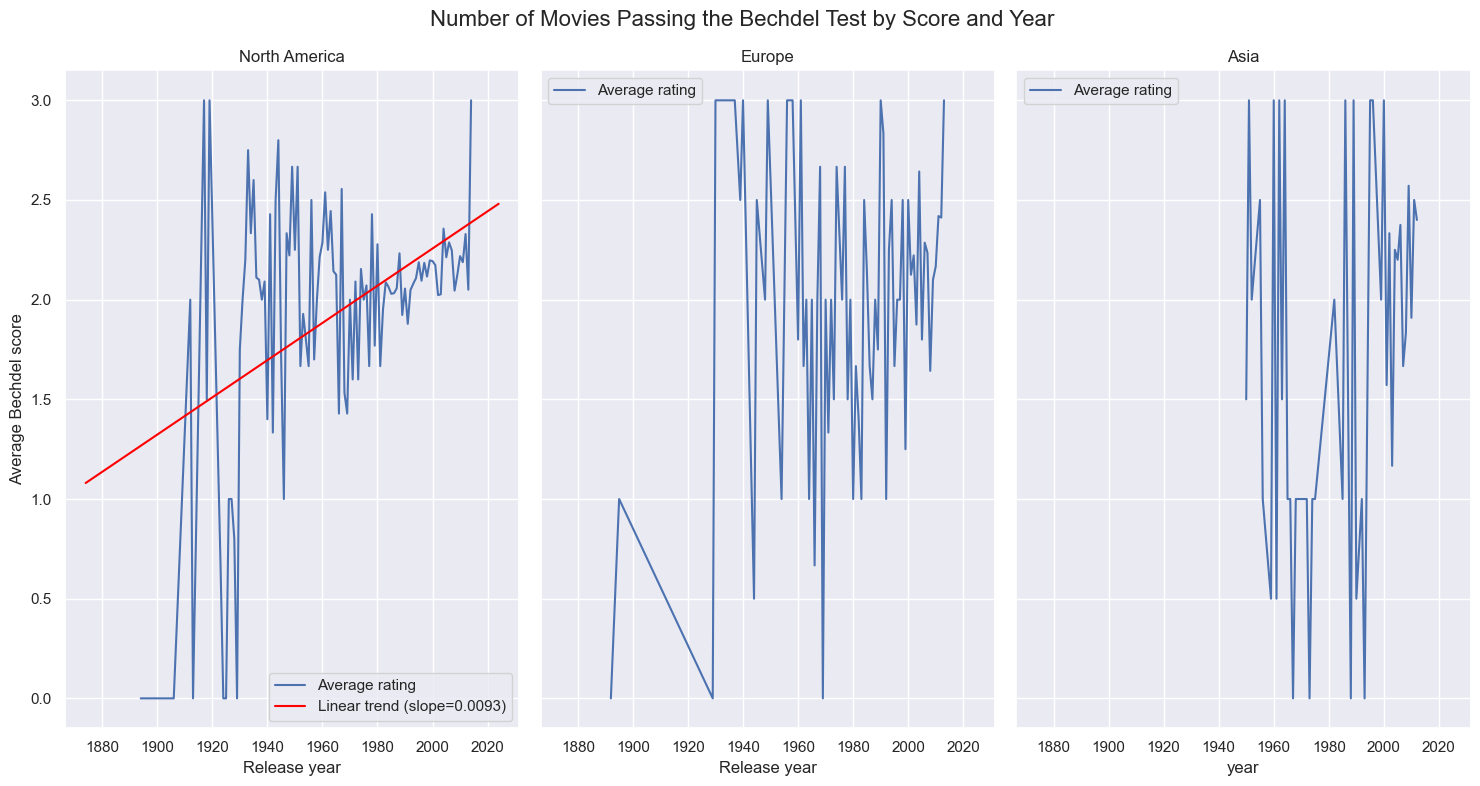

In [16]:
sns.set_theme()

fig, axes = plt.subplots(1,3, figsize = (15,8), sharex=True, sharey = True)

fig.suptitle('Number of Movies Passing the Bechdel Test by Score and Year', fontsize=16)

sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_NA', label = 'Average rating',ax=axes[0]).set(title='North America',
                                                                                                                  ylabel = 'Averge')
slope_NA, intercept_NA, rvalue_NA, pvalue_NA, stderr = stats.linregress(df_avg_continent.loc[df_avg_continent['avg_bechdel_score_NA'].notna(),'year'], 
                                                            df_avg_continent.loc[df_avg_continent['avg_bechdel_score_NA'].notna(), 'avg_bechdel_score_NA'])
print(f"For North America: Pearson Correlation Coefficient: {rvalue_NA:.4f}, p-value: {pvalue_NA}, intercept={intercept_NA:.2f}")

axes[0].plot(df_year_bechdel['year'],slope_NA * df_year_bechdel['year'] + intercept_NA,color='red',label=f'Linear trend (slope={slope_NA:.4f})')

axes[0].set_xlabel('Release year')
axes[0].set_ylabel('Average Bechdel score')
axes[0].legend()

sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_EU', label = 'Average rating',ax=axes[1]).set(title='Europe',
                                                                                                                  ylabel = '# of movies')
slope, intercept, rvalue_EU, pvalue, stderr = stats.linregress(df_avg_continent.loc[df_avg_continent['avg_bechdel_score_EU'].notna(),'year'], 
                                                            df_avg_continent.loc[df_avg_continent['avg_bechdel_score_EU'].notna(), 'avg_bechdel_score_EU'])


axes[1].set_xlabel('Release year')
axes[1].set_ylabel('Average Bechdel score')
axes[1].legend()

sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_AS', label = 'Average rating',ax=axes[2]).set(title='Asia')

plt.tight_layout();





As anticipated, the limited number of European and Asian films in the database prevented us from obtaining meaningful results for these regions. Consequently, the Bechdel test results can only be reliably analyzed for North American films.

The overrepresentation of American films in the Bechdel test database means that the results for the entire dataset are likely skewed and not fully representative of global trends, though they do offer insights specific to North America.

Nonetheless, as expected, the trend observed for North American films closely aligns with the findings from the merged Bechdel test dataset.

### Female actresses

We will here analyze the impact of the number of female actresses in a movie. Either By genre, or its relatedness to the Bechdel test

In [17]:
#For readability, we are going to set the wikipedia id as index

column_names = ['movie_freebase_id', 'release_date','character_name','birth','gender','character_height', 'actor_ethnicity',
                'actor_name','actor_age', 'actor_gender_freebase_id','character_freebase_id','freebase_character_map']

df_characters=pd.read_csv(data_folder+'/character.metadata.tsv', sep= '\t', names = column_names)

df_characters.index.name='wikipedia_movie_id'

df_characters.sample(5)

,movie_freebase_id,release_date,character_name,birth,gender,character_height,actor_ethnicity,actor_name,actor_age,actor_gender_freebase_id,character_freebase_id,freebase_character_map
wikipedia_movie_id,,,,,,,,,,,,
15351941,/m/03m5y23,2008,NaN,NaN,NaN,NaN,NaN,Gherardo Crucitti,NaN,/m/0h4yr3b,NaN,/m/0h4yr3d
6838264,/m/0grwkk,1995-03-31,NaN,1918-05-31,F,NaN,NaN,Sadie Corré,76.0,/m/0bntl41,NaN,/m/07k5y09
935996,/m/03rhx9,1990-02-16,NaN,NaN,NaN,NaN,NaN,Gerardo Zepeda,NaN,/m/0gc42q6,NaN,/m/0gbwn95
25788981,/m/09v3gbh,1930-02-01,NaN,1912-11-14,M,NaN,NaN,Tito Davison,17.0,/m/0hvwdbt,NaN,/m/05b4zrw
14514572,/m/03d5_pm,1981-10-11,Justine Winfield,NaN,F,NaN,NaN,Suzy Block,NaN,/m/0lqwgj2,/m/0lr3z37,/m/0lqwgj5


#### Connection between the number of lead female actresses and the Bechdel test score

In [18]:
female_counts = df_characters[df_characters['gender'] == 'F'].groupby('wikipedia_movie_id').size().reset_index(name='nbr_female_actresses')

# Merge the counts into df_movies_bechdel, ensuring all rows from df_movies_bechdel are retained (left join)
df_movies_bechdel_characters = df_movies_bechdel.merge(female_counts, on='wikipedia_movie_id', how='left')


df_movies_bechdel_characters.sample(5)

,wikipedia_movie_id,freebase_id,title,release_date,revenue,runtime,language,countries,genre,year,imdbid,bechdel_score,continent,nbr_female_actresses
3004,1026452,/m/03_f9d,Fantastic Voyage,1966-08-24,12000000.0,101.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",1966.0,0060397,0,NA,2.0
838,3843878,/m/02vkdjr,Outsourced,2006-09-12,703042.0,103.0,"{""/m/03k50"": ""Hindi Language"", ""/m/02h40lc"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0219x_"": ""...",2006.0,0425326,1,NA,3.0
2776,29303900,/m/0ds6bmk,Tyrannosaur,2011-01-21,NaN,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/07s9rl0"": ""Drama""}",2011.0,1204340,2,EU,6.0
1765,14545761,/m/03d79mp,17 Again,2009-03-11,136267476.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/01j1n2"": ""...",2009.0,0974661,3,NA,8.0
2682,19715,/m/04zqb,Miss Congeniality,2000-12-14,NaN,109.0,"{""/m/064_8sq"": ""French Language"", ""/m/06nm1"": ...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/06cvj"": ""Romantic comedy"", ""/m/01jfsb"": ""...",2000.0,0212346,3,NA,5.0


We will start by doing a scatterplot between the Bechdel test score of a film, and the number of female actors in the film.

Pearson correlation: 0.35728094104498753, p-value: 6.669666618540747e-91


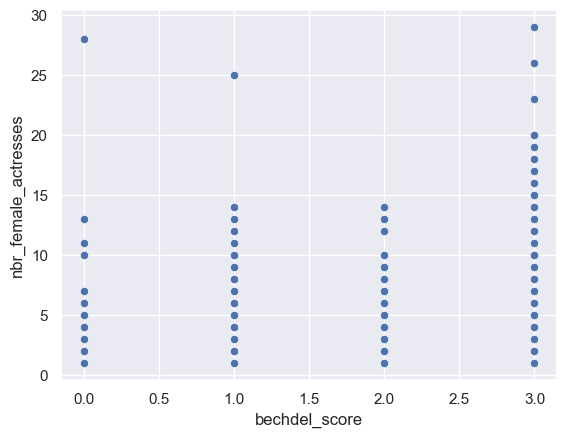

In [19]:
sns.scatterplot(data=df_movies_bechdel_characters, y='nbr_female_actresses',x='bechdel_score')

valid_data = df_movies_bechdel_characters[df_movies_bechdel_characters['nbr_female_actresses'].notna()]

correlation, p_value = stats.pearsonr(valid_data['nbr_female_actresses'], valid_data['bechdel_score'])

print(f"Pearson correlation: {correlation}, p-value: {p_value}")

Nevertheless, we need to remind ourselves that this is probably not an independent variable, and we need to also study the number of female actresses along the years.

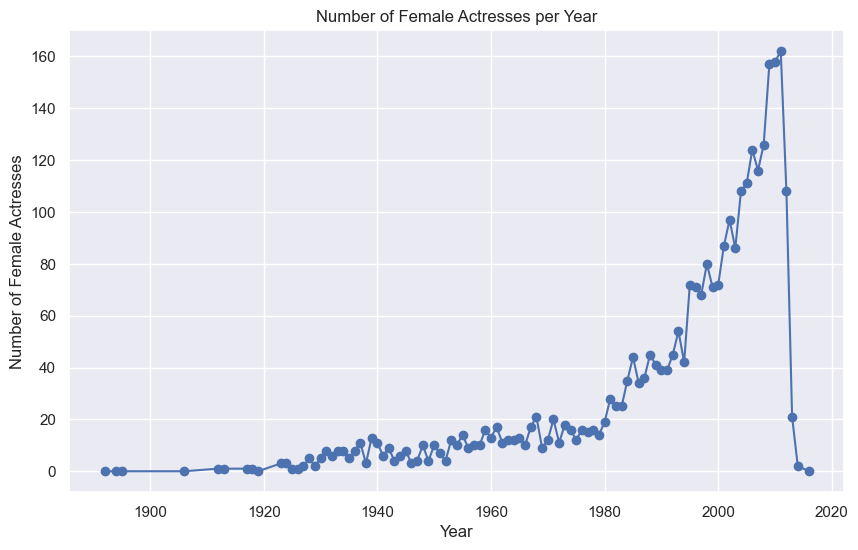

Pearson correlation: 0.7193585617108028, p-value: 1.6441309918845186e-17


In [20]:


df_year_female_actresses = df_movies_bechdel_characters.groupby('year')['nbr_female_actresses'].agg('count').reset_index()

# Step 3: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_year_female_actresses['year'], df_year_female_actresses['nbr_female_actresses'], marker='o', linestyle='-', color='b')
plt.title('Number of Female Actresses per Year')
plt.xlabel('Year')
plt.ylabel('Number of Female Actresses')
plt.grid(True)
plt.show()

correlation,p_value =stats.pearsonr(df_year_female_actresses['year'],df_year_female_actresses['nbr_female_actresses'])

print(f"Pearson correlation: {correlation}, p-value: {p_value}")



Here's an improved version of your comment that leaves the idea open for future exploration:

The correlation observed between the Bechdel test results and the success ratio is significantly stronger than the correlation between the Bechdel test and the number of female actresses in a film. This suggests that the mere presence of female characters may not be as influential as their representation quality when it comes to film success.

To delve deeper into these dynamics, a potential next step could involve exploring the relationships between the following variables using a propensity score analysis:

1. Bechdel Test result: Indicates the level of female representation.
2. Number of female actresses: Reflects the numerical presence of women in the film.
3. Year: Accounts for historical trends and evolving industry practices.

Such an analysis could help isolate the impact of each factor and uncover whether these variables have a combined effect on the portrayal of women in cinema and the overall success of films. This could provide a more nuanced understanding of how female representation has evolved over time and its influence on film performance.

The following code is to output the number of female actresses that participate per main genre. (je ne sais pas trop quoi faire avec ça lol, c'est moche et je vois pas où je peux/veux en venir)

primary_genre
Thriller                703
Romantic comedy         297
Crime Fiction           237
Drama                   208
Science Fiction         135
                       ... 
Kitchen sink realism      1
Live action               1
Film adaptation           1
Pornographic movie        1
Concert film              1
Name: count, Length: 144, dtype: int64

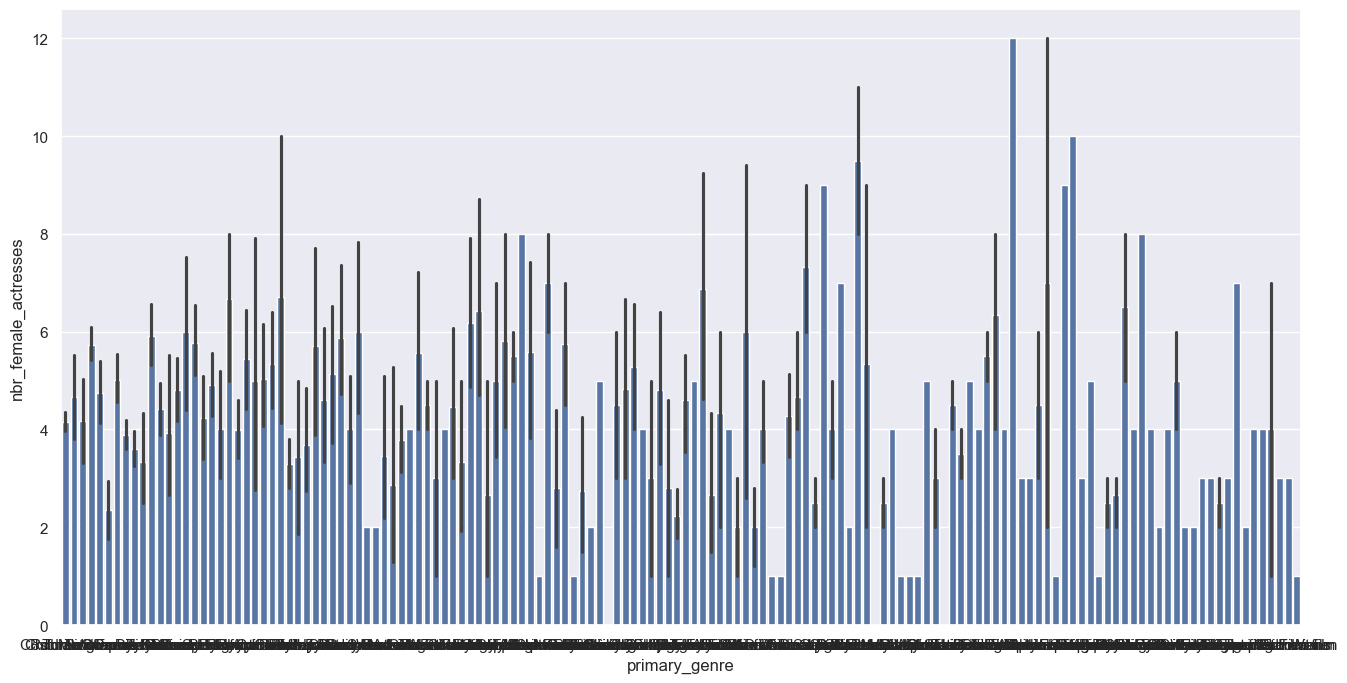

In [21]:
#We will no

def get_primary_genre(genre_list):
    try:
        genre_dict=json.loads(genre_list)

        if not genre_dict:
            return None

        primary_genre = list(genre_dict.values())[0]
        return primary_genre
    except KeyError or IndexError:
        return None


df_movies_bechdel_characters['primary_genre'] = df_movies_bechdel_characters['genre'].apply(get_primary_genre)

plt.figure(figsize=(16, 8))
sns.barplot(data=df_movies_bechdel_characters, y='nbr_female_actresses',x='primary_genre')

df_movies_bechdel_characters['primary_genre'].value_counts()


In [22]:
df_clean_data_success=pd.read_csv(data_folder + 'clean_data_success.csv')

df_clean_data_success.head()

df_clean_data_success.rename(columns={"Year":"year"})

,Unnamed: 0.1,Unnamed: 0,Wiki_ID,Movie_ID,title,release_date,BoxOfficeRevenue,Runtime,Languages,Countries,Genres,year,BoxOfficeStandardize,budget,Net_revenue,rating,BoxOfficeRank,RatingRank,SuccessMetric
0,0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,0.005032,28000000.0,-13989168.0,4.850459,0.093178,0.089868,0.091523
1,1,7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,0.001290,2000000.0,1600000.0,5.800000,0.332501,0.289639,0.311070
2,2,13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,0.003649,9000000.0,1161099.0,7.450000,0.323627,0.903072,0.613350
3,3,17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,0.036755,6000000.0,96272727.0,7.600000,0.811703,0.931883,0.871793
4,4,29,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",2001,0.010557,16000000.0,13381649.0,6.900000,0.490294,0.732303,0.611298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236,5236,81649,9271903,/m/0282j29,Trois,2000,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",2000,NaN,200000.0,NaN,4.200000,NaN,0.040832,NaN
5237,5237,81657,303933,/m/01s7w3,Twister,1996-05-10,494471524.0,113.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/01drsx""...",1996,0.177719,92000000.0,402471524.0,6.300000,0.974487,0.479966,0.727226
5238,5238,81659,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2011,0.052951,32000000.0,115332697.0,7.300000,0.845535,0.863289,0.854412
5239,5239,81695,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",1988,0.103780,39000000.0,249752301.0,6.800000,0.940100,0.694238,0.817169


We use the code to mix film database and Bechdel once again

In [23]:
#We are going to create a database where we merge the bechdel and the movie database, so that we can have all of the information of those films 
# in one single dataframe. We will merge it on year and title, to avoid having one title of he Bechdel database to many movies in the movie database.

# Convert release_date to datetime format (if it's not already in datetime)
df_clean_data_success['release_date'] = pd.to_datetime(df_clean_data_success['release_date'], errors='coerce')

# Extract the year from the release_date column
df_clean_data_success['year'] = df_clean_data_success['release_date'].dt.year

# Merge the datasets by 'title' and 'year'
df_succes_bechdel = pd.merge(df_clean_data_success, df_bechdel, how='inner', on=['title', 'year'])



df_succes_bechdel = df_succes_bechdel.rename(columns={'rating_y':'bechdel_score'})
df_succes_bechdel = df_succes_bechdel.drop_duplicates(['title','Wiki_ID'])

print(f'The combined Bechdel and CMU Movies database has {df_succes_bechdel.shape[0]} films')

df_succes_bechdel.head()

The combined Bechdel and CMU Movies database has 1833 films


,Unnamed: 0.1,Unnamed: 0,Wiki_ID,Movie_ID,title,release_date,BoxOfficeRevenue,Runtime,Languages,Countries,...,budget,Net_revenue,rating_x,BoxOfficeRank,RatingRank,SuccessMetric,year,id,imdbid,bechdel_score
0,0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",...,28000000.0,-13989168.0,4.850459,0.093178,0.089868,0.091523,2001.0,333,0228333,3
1,2,13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",...,9000000.0,1161099.0,7.450000,0.323627,0.903072,0.613350,1989.0,2353,0097499,3
2,3,17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",...,6000000.0,96272727.0,7.600000,0.811703,0.931883,0.871793,1964.0,701,0058331,3
3,9,126,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",...,14320000.0,-10320000.0,6.200000,0.129229,0.446766,0.287997,1968.0,2092,0063642,3
4,12,151,1305819,/m/04rjwf,C.H.U.D.,1984-08-31,4650000.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",...,1250000.0,3400000.0,5.450000,0.369662,0.194333,0.281997,1984.0,9327,0087015,2


We are here going to check the correlation between the SuccessRatio variable and the Bechdel test result of movies. To try and find a relationship between the success of a film and the completeness of women representation in these films.

Pearson correlation: -0.10874917207608291, p-value: 1.3788376035157457e-05


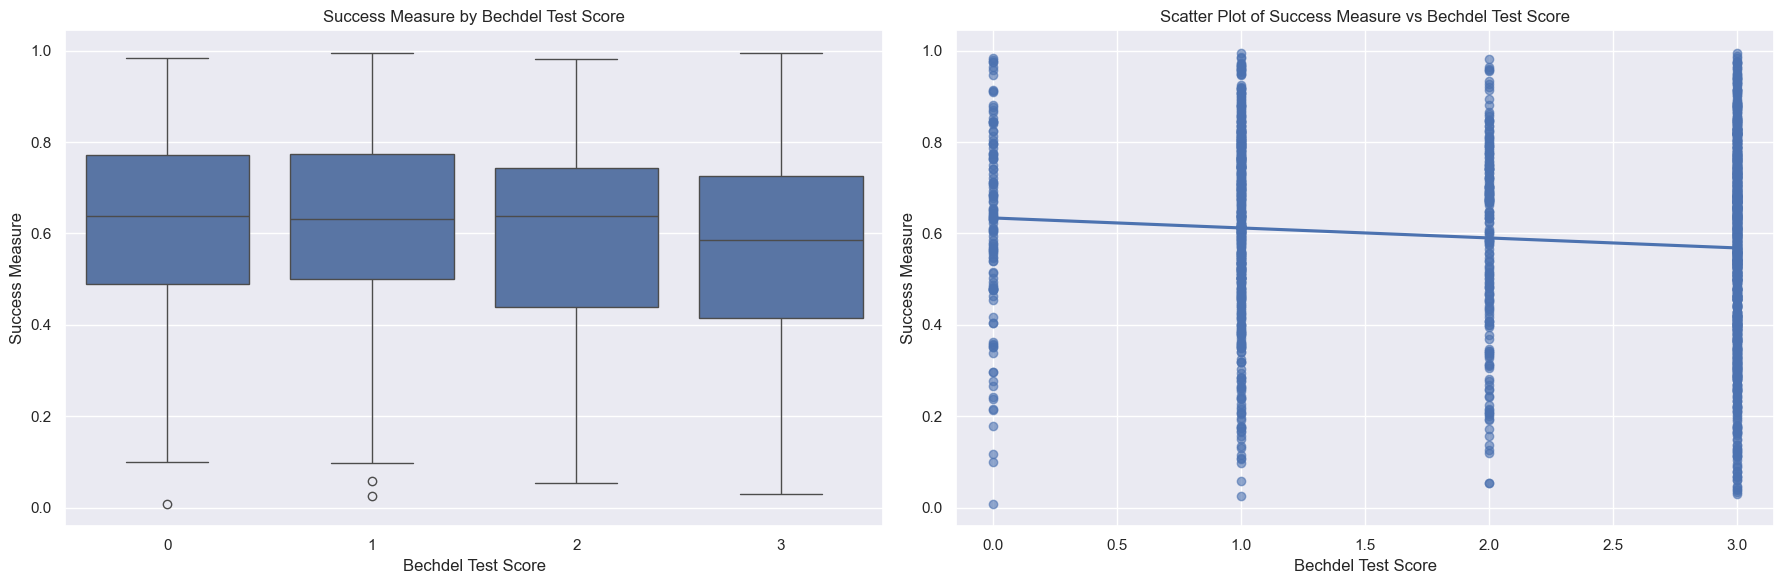

In [26]:
valid_data = df_succes_bechdel[df_succes_bechdel['SuccessMetric'].notna()]

correlation, p_value = stats.pearsor(valid_data['SuccessMetric'], valid_data['bechdel_score'])

print(f"Pearson correlation: {correlation}, p-value: {p_value}")

# Set up the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: Box Plot by Bechdel Score
sns.boxplot(data=df_succes_bechdel, x='bechdel_score', y='SuccessMetric', ax=axes[0])
axes[0].set_title('Success Measure by Bechdel Test Score')
axes[0].set_xlabel('Bechdel Test Score')
axes[0].set_ylabel('Success Measure')

# Subplot 2: Scatter Plot with Linear Regression
sns.regplot(data=df_succes_bechdel, x='bechdel_score', y='SuccessMetric', ax=axes[1], 
            ci=None, scatter_kws={'alpha':0.6})
axes[1].set_title('Scatter Plot of Success Measure vs Bechdel Test Score')
axes[1].set_xlabel('Bechdel Test Score')
axes[1].set_ylabel('Success Measure')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


From these results, we observe that it is statistically significant (given the small p-value) that there is a slight negative correlation between the Bechdel test score and the success measure of a film. In other words, as a film's success rating increases, its Bechdel test score appears to decrease slightly.

However, since the Pearson Correlation Coefficient is below 0.2, this correlation is quite weak and unlikely to be meaningful. This suggests that the Bechdel test result of a film is not strongly correlated with its success metrics.

Thus, based on this analysis, it can be inferred that a film's success is likely not dependent on the complexity of interactions between female characters, as measured by the Bechdel test. This indicates that other factors are more influential in driving a film's success, beyond just the representation of female interactions.

### Continuation:
Investigate how more nuanced interactions between female characters influence a film’s success, potentially using propensity score analysis to control for variables such as genre, number of female actresses, or release year. This would help isolate the specific impact of female representation on a film’s performance.

### Next step:
After the upcoming lectures on "Handling Text Data," we could explore methods to analyze which lexical fields in film summaries are more frequently associated with higher Bechdel test scores. This could help uncover particular themes or storylines that are linked to improved representation of women in films.






